In [2]:
# Imports
import random
import numpy as np
from scipy.spatial import Voronoi, voronoi_plot_2d
import matplotlib.pyplot as plt
from math import sqrt
from skimage import io, color, data, transform
from skimage.morphology import skeletonize
from skimage.util import invert
from PIL import Image

# Voronoi diagrams

A Voronoi diagram is a partitioning of a plane into regions based on a set of predefined points ${p_1 ... p_n}$ . The region of each point $p_i$ in this set consists of every point in the Euclidean plane which is closer to $p_i$ than to any other point of the set.

A Voronoi diagram of 100 random points with $0 \leqslant x < 100$, $0 \leqslant y < 100$:

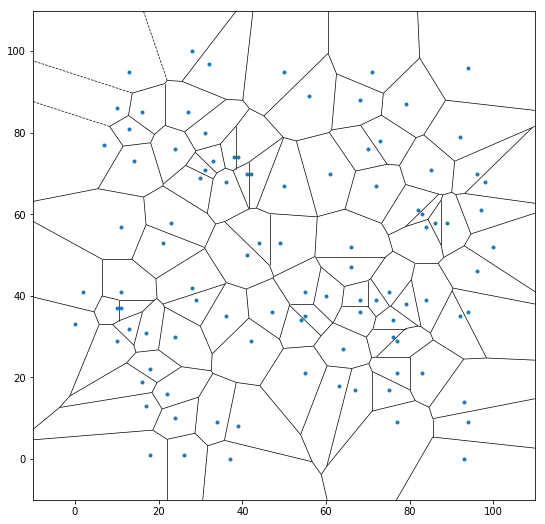

In [108]:
# Create Voronoi object from an array
points = np.array([[random.randint(0,100), random.randint(0,100)] for i in range(100)])
vor = Voronoi(points)

# Show plot
voronoi_plot_2d(vor, line_width = 0.7, show_vertices = False, show_points = True)
fig_size = plt.rcParams["figure.figsize"]
fig_size = (9, 9)
plt.rcParams["figure.figsize"] = fig_size
plt.show()

In [110]:
# Inspect first 5 points
vor.points[:5]

array([[ 17.,  31.],
       [ 36.,  68.],
       [ 94.,  36.],
       [ 47.,  36.],
       [ 61.,  70.]])

In [111]:
# Inspect first 5 vertices
vor.vertices[:5]

array([[  65.        ,  -31.05555556],
       [  22.04545455,   92.86363636],
       [-201.375     ,   87.59375   ],
       [ 116.42857143,   36.71428571],
       [  46.5       ,   60.21428571]])

# Image preprocessing

We reduce the image to a 1-pixel outline.

In [118]:
def get_skeleton_points(filename):
    # Read image as grayscale, round to 0's and 1's, invert
    image = invert(color.rgb2gray(io.imread(filename)).round())
    # Skeletonize image
    skeleton = skeletonize(image)
    
    # Display results
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 4),
                             sharex=True, sharey=True,
                             subplot_kw={'adjustable': 'box-forced'})
    ax = axes.ravel()
    ax[0].imshow(image, cmap=plt.cm.gray)
    ax[0].axis('off')
    ax[0].set_title('original', fontsize=20)

    ax[1].imshow(skeleton, cmap=plt.cm.gray)
    ax[1].axis('off')
    ax[1].set_title('skeleton', fontsize=20)

    fig.tight_layout()
    plt.show()

    # Make array of skeleton points
    skeleton_points = [[np.where(skeleton == True)[0][i], np.where(skeleton == True)[1][i]]
              for i in range(len(np.where(skeleton == True)[0]))]
    return skeleton_points

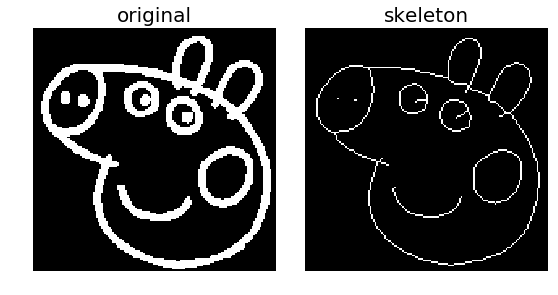

In [119]:
sk_pts = get_skeleton_points('pics/peppa.png')

Get shape of the image to determine size of the diagrams:

In [123]:
def get_image_shape(filename):
    return color.rgb2gray(io.imread(filename)).shape

In [127]:
get_image_shape('pics/peppa.png')

(150, 150)

Get skeleton of an image to display:

In [141]:
def get_skeleton(filename):
    # Read image as grayscale, round to 0's and 1's, invert
    image = invert(color.rgb2gray(io.imread(filename)).round())
    # Skeletonize image
    return skeletonize(image)

# Fitness functions and genetic algorithm

Generating random initial populations:

In [128]:
def population(n_points, pop_size, fig_height, fig_width):
    # Generate an array of Voronoi objects
    pop = []
    for i in range(pop_size):
        points = np.array([[random.randint(0, fig_width), random.randint(0, fig_height)] for i in range(n_points)])
        pop.append(Voronoi(points))
    return pop

Introducing mutation into a single diagram to generate a new population:

In [139]:
def newpop(diagram, pop_size=30, mut_rate=0.1, mut_step=3):
    n_points = len(diagram.points)
    pop = []
    for o in range(pop_size):
        # Select points for mutation
        mut_indices = np.random.choice(range(n_points), int(n_points*mut_rate), replace=False)
        # Introduce mutation
        mut_points = np.array([[point[0] + random.choice(range(-mut_step, mut_step+1)),
                                point[1] + random.choice(range(-mut_step, mut_step+1))] 
                                if i in mut_indices
                                else point
                                for i, point in enumerate(diagram.points)])
        pop.append(Voronoi(mut_points))
    return pop

## 1. Sum of distances vertex--skeleton

Define Euclidean distance:

In [129]:
def eucl_dist(pt1, pt2):
    # Euclidean distance between two points
    return sqrt((pt1[0] - pt2[0])**2 + (pt1[1] - pt2[1])**2)

Define cost function (sum of distances vertex--skeleton):

In [130]:
def fitness_function(voronoi, skeleton_points):
    total = 0
    # Find closest skeleton point for each Voronoi vertex
    closest_sk_pt = [sorted(skeleton_points, key=lambda x: eucl_dist(point, x))[0] for point in voronoi.vertices]
    # Sum distances
    for i in range(len(voronoi.vertices)):
        total += eucl_dist(voronoi.vertices[i], closest_sk_pt[i])
    return total

In [131]:
fitness_function(vor, sk_pts)

2910.6010572933124

Genetic optimization:

In [137]:
def gen_best(n_generations, n_points, pop=[], pop_size=30, fig_width=100, fig_height=100, n_top=5,
             mut_rate=0.1, mut_step=3, skeleton_points=sk_pts):
    # If population not specified, create a random one
    if not pop:
        pop = population(n_points, pop_size, fig_width, fig_height)
    # Selection: choose top individuals
    chosen = sorted(pop, key=lambda x: fitness_function(x, skeleton_points))[:n_top]
    # Calculate top score
    best_score = fitness_function(chosen[0], skeleton_points)
    
    for g in range(n_generations):
        try:
            # Print out current results
            print('Generation:', g, 'Best score:', best_score, end='\r')
            new_gen = []
            # Choose points to replicate from each parent
            offspring_points = np.array([chosen[random.choice(range(n_top))].points[i] for i in range(n_points)])
            # Crossover: create an offspring
            offspring = Voronoi(offspring_points)

            # Mutation
            for o in range(pop_size):
                # Select points for mutation
                mut_indices = np.random.choice(range(n_points), int(n_points*mut_rate), replace=False)
                # Mutate points
                mut_points = np.array([[point[0] + random.choice(range(-mut_step, mut_step+1)),
                                        point[1] + random.choice(range(-mut_step, mut_step+1))] 
                                       if i in mut_indices
                                       else point
                                       for i, point in enumerate(offspring.points)])
                new_gen.append(Voronoi(mut_points))
            pop = new_gen
            # Selection: choose top individuals
            chosen = sorted(pop, key=lambda x: fitness_function(x, skeleton_points))[:n_top]
            # Calculate top score
            best_score = fitness_function(chosen[0], skeleton_points)
        except KeyboardInterrupt:
            return chosen[0]
    return chosen[0]

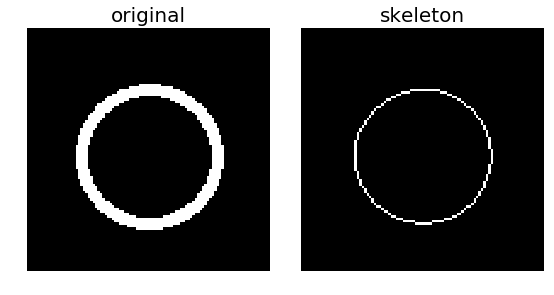

In [153]:
circle = gen_best(n_generations=400, n_points=30, fig_height=get_image_shape('pics/circle.png')[0],
                  fig_width=get_image_shape('pics/circle.png')[1], skeleton_points=get_skeleton_points('pics/circle.png'))

Display result:

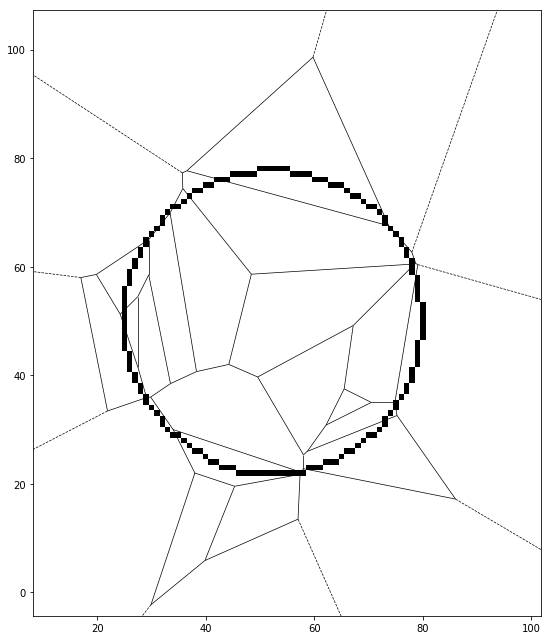

In [154]:
voronoi_plot_2d(circle, line_width = 0.7, show_vertices = False, show_points = False)
io.imshow(transform.rotate(invert(get_skeleton('pics/circle.png')[:, ::-1]), 90))
plt.show()

## 2. Sum of top shortest distances vertex--skeleton¶

Define cost function (sum of shortest distances vertex--skeleton):

In [144]:
def fitness_function_top(voronoi, skeleton_points=sk_pts, top_rate=0.7):
    vertices = list(list(v) for v in voronoi.vertices)
    # Calculate distances from each vertex to its closest point of the skeleton
    skeleton_distances = [sorted([eucl_dist(v, sk_point) for sk_point in skeleton_points])[0] for v in vertices]    
    top_n = int(len(vertices) * top_rate)
    # Sort distnces by length
    top_distances = sorted(skeleton_distances)
    # Sum shortest distances
    total = sum(top_distances[:top_n])
    return total

Genetic optimization:

In [ ]:
def gen_best_top(n_generations, n_points, pop=[], pop_size=30, fig_width=100, fig_height=100, n_top=5,
                 mut_rate=0.1, mut_step=3, skeleton_points=sk_pts):
    # If population not specified, generate random one
    if not pop:
        pop = population(n_points, pop_size, fig_width, fig_height)
    # Selection: choose top individuals
    chosen = sorted(pop, key=lambda x: fitness_function_top(x, skeleton_points))[:n_top]
    # Calculate top score
    best_score = fitness_function_top(chosen[0], skeleton_points)
    
    for g in range(n_generations):
        try:
            # Print out current results
            print('Generation:', g, 'Best score:', best_score, end='\r')
            new_gen = []
            # Choose genes to replicate from each parent
            offspring_points = np.array([chosen[random.choice(range(n_top))].points[i] for i in range(n_points)])
            # Crossover: create a new individual from chosen parents' genes
            offspring = Voronoi(offspring_points)

            for o in range(pop_size):
                # Select points for mutation
                mut_indices = np.random.choice(range(n_points), int(n_points*mut_rate), replace=False)
                # Introduce mutation to chosen points
                mut_points = np.array([[point[0] + random.choice(range(-mut_step, mut_step+1)),
                                        point[1] + random.choice(range(-mut_step, mut_step+1))] 
                                       if i in mut_indices
                                       else point
                                       for i, point in enumerate(offspring.points)])
                new_gen.append(Voronoi(mut_points))
            pop = new_gen
            # Selection: choose top individuals
            chosen = sorted(pop, key=lambda x: fitness_function_top(x, skeleton_points))[:n_top]
            # Calculate top score
            best_score = fitness_function_top(chosen[0], skeleton_points)
        except KeyboardInterrupt:
            return chosen[0]
    return chosen[0]

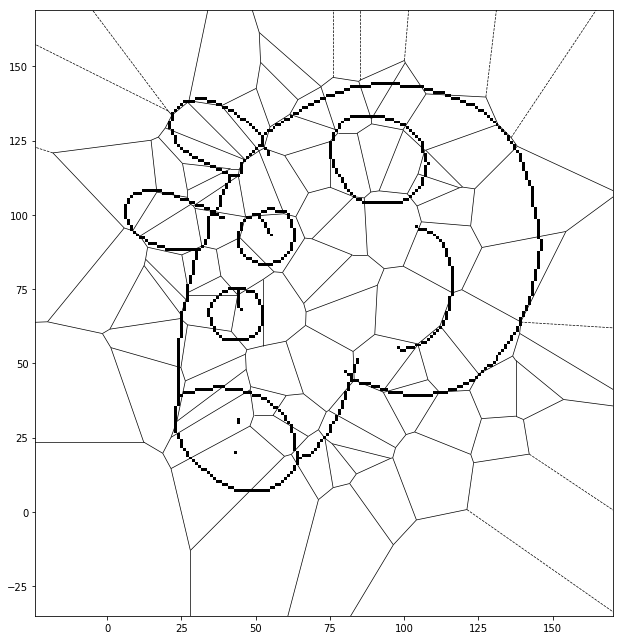

In [228]:
voronoi_plot_2d(mygen_top, line_width = 0.7, show_vertices = False, show_points = False)
io.imshow(transform.rotate(invert(skeleton[:, ::-1]), 90))
plt.show()

In [231]:
%%time
overnight_peppa = gen_best_top(n_generations=1000, n_points=120, fig_height=150, fig_width=150, pop_size=50)

Wall time: 4h 24min 8s


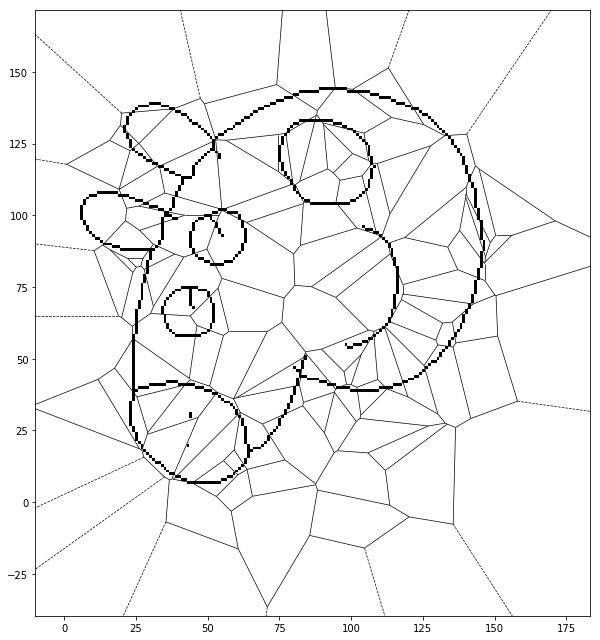

In [237]:
voronoi_plot_2d(overnight_peppa, line_width = 0.7, show_vertices = False, show_points = False)
io.imshow(transform.rotate(invert(skeleton[:, ::-1]), 90))
plt.show()

In [245]:
%%time
peppa_120pts_1rate = gen_best_top(n_generations=400, mut_rate=0.1, n_points=120, fig_height=150, fig_width=150, mut_step=3)

Wall time: 1h 27min 3s


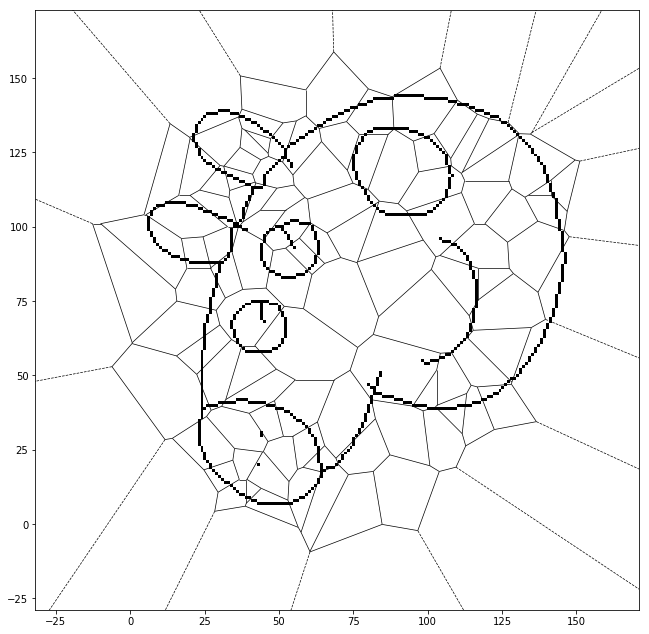

In [268]:
voronoi_plot_2d(peppa_120pts_1rate, line_width = 0.7, show_vertices = False, show_points = False)
io.imshow(transform.rotate(invert(skeleton_weyes[:, ::-1]), 90))
plt.show()

In [250]:
peppa_120pts_1rate_cont = gen_best_top(n_generations=200, n_points=120, fig_height=150, fig_width=150,
                                       pop=newpop(diagram=peppa_120pts_1rate, mut_rate=0.1, mut_step=3, pop_size=30))

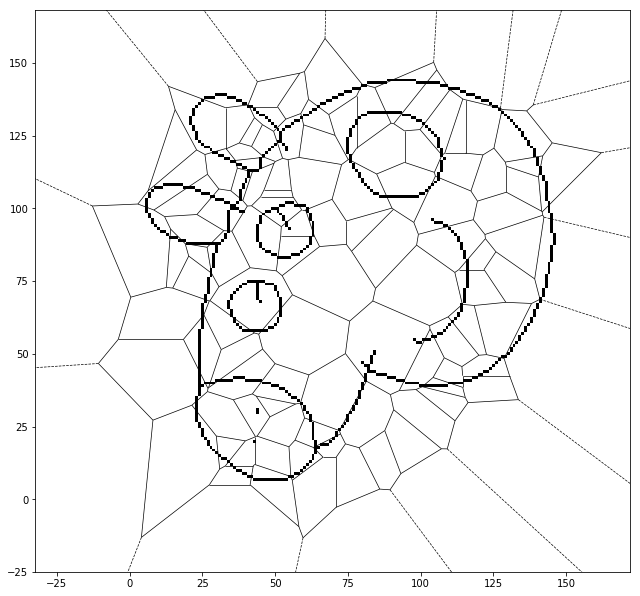

In [251]:
voronoi_plot_2d(peppa_120pts_1rate_cont, line_width = 0.7, show_vertices = False, show_points = False)
io.imshow(transform.rotate(invert(skeleton[:, ::-1]), 90))
plt.show()

In [265]:
peppa_120pts_1rate_cont2 = gen_best_top(n_generations=200, n_points=120, fig_height=150, fig_width=150,
                                       pop=newpop(diagram=peppa_120pts_1rate, mut_rate=0.1, mut_step=3, pop_size=30))

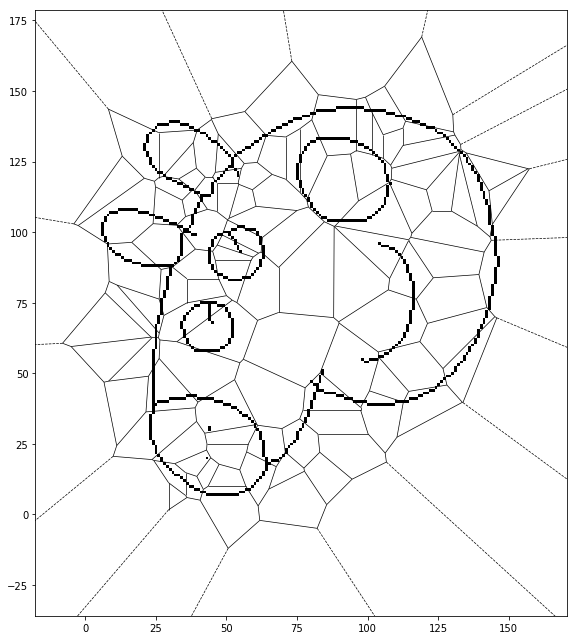

In [266]:
voronoi_plot_2d(peppa_120pts_1rate_cont2, line_width = 0.7, show_vertices = False, show_points = False)
io.imshow(transform.rotate(invert(skeleton_weyes[:, ::-1]), 90))
plt.show()

## 3. Generating initial population with centroids on the image skeleton

Generate population:

In [150]:
def population_on_skeleton(n_points, pop_size, fig_width, fig_height, skeleton_points):
    pop = []
    for i in range(pop_size):
        # Choose skeleton points to put centroids on
        points = np.array(sorted(skeleton_points, key=lambda x: x[0] + x[1])[0::int(len(sk_pts)/n_points)])
        pop.append(Voronoi(points))
    return pop

Genetic optimizaion:

In [151]:
def gen_best_from_sk(n_generations, n_points, pop=[], pop_size=30, fig_width=100, fig_height=100,
                     n_top=5, mut_rate=0.1, mut_step=3, skeleton_points=sk_pts):
    # If initial population not specified, generate new
    if not pop:
        pop = population_on_skeleton(n_points, pop_size, fig_width, fig_height, skeleton_points)
    # Selection: choose top individuals for crossover
    chosen = sorted(pop, key=lambda x: fitness_function_top(x, skeleton_points))[:n_top]
    # Calculate best score
    best_score = fitness_function_top(chosen[0], skeleton_points)
    
    for g in range(n_generations):
        try:
            # Print out current results
            print('Generation:', g, 'Best score:', best_score, end='\r')
            new_gen = []
            # Choose points to replicate from each parent
            offspring_points = np.array([chosen[random.choice(range(n_top))].points[i] for i in range(n_points)])
            # Crossover
            offspring = Voronoi(offspring_points)

            for o in range(pop_size):
                # Select points for mutation
                mut_indices = np.random.choice(range(n_points), int(n_points*mut_rate), replace=False)
                # Introduce mutation
                mut_points = np.array([[point[0] + random.choice(range(-mut_step, mut_step+1)),
                                        point[1] + random.choice(range(-mut_step, mut_step+1))] 
                                       if i in mut_indices
                                       else point
                                       for i, point in enumerate(offspring.points)])
                new_gen.append(Voronoi(mut_points))
            pop = new_gen
            # Selection: choose top individuals
            chosen = sorted(pop, key=lambda x: fitness_function_top(x, skeleton_points))[:n_top]
            # Calculate best score
            best_score = fitness_function_top(chosen[0], skeleton_points)
        except KeyboardInterrupt:
            return chosen[0]
    return chosen[0]

In [105]:
check_test = gen_best_from_sk(fig_height=100, fig_width=100, n_generations=400, skeleton_points=sk_pts, n_points=40)

c:\users\eliza\appdata\local\programs\python\python36-32\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:74: UserWarning: Low image data range; displaying image with stretched contrast.
  warn("Low image data range; displaying image with "


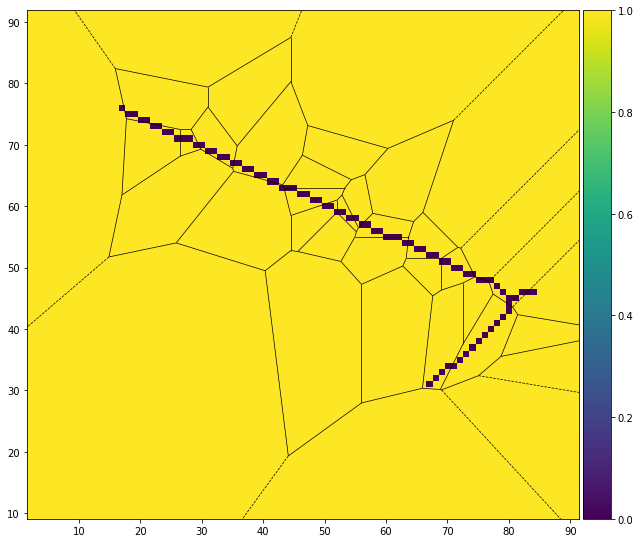

In [106]:
voronoi_plot_2d(check_test, line_width = 0.7, show_vertices = False, show_points = False)
io.imshow(transform.rotate(invert(skeleton_peppa[:, ::-1]), 90))
plt.show()

In [328]:
peppa_on_skeleton = gen_best_from_sk(n_generations=300, n_points=100, fig_height=150, fig_width=150)

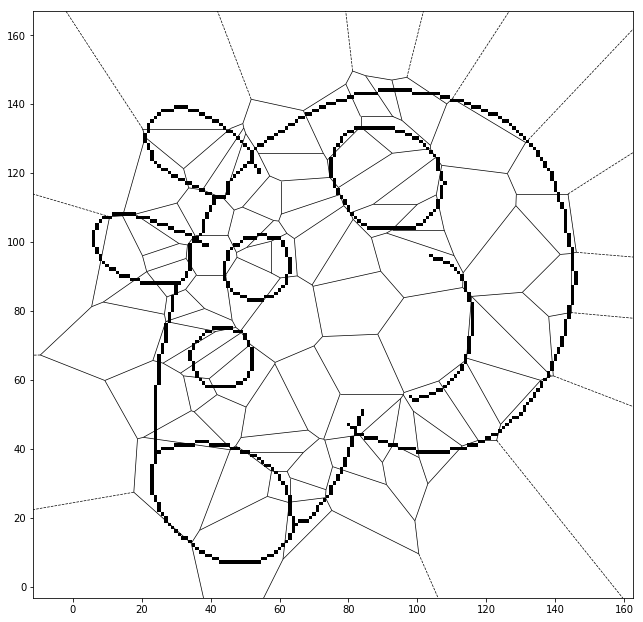

In [329]:
voronoi_plot_2d(peppa_on_skeleton, line_width = 0.7, show_vertices = False, show_points = False)
io.imshow(transform.rotate(invert(skeleton_circle[:, ::-1]), 90))
plt.show()

In [343]:
peppa_on_skeleton_intervals = gen_best_from_sk(n_generations=300, n_points=100, fig_height=150, fig_width=150)

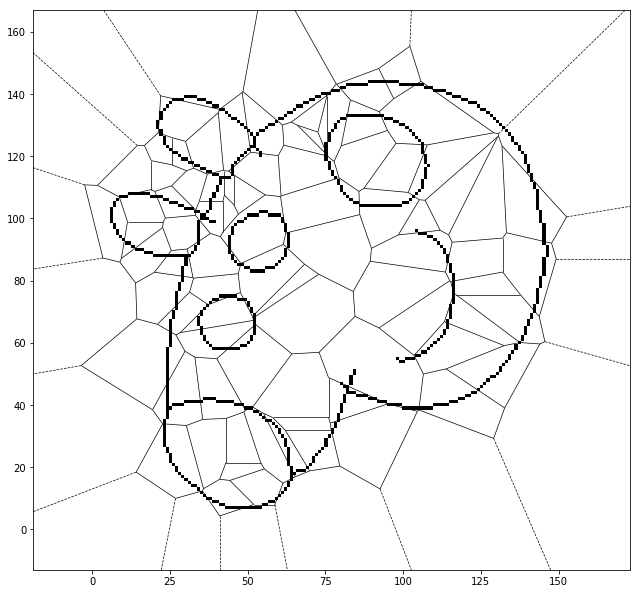

In [344]:
voronoi_plot_2d(peppa_on_skeleton_intervals, line_width = 0.7, show_vertices = False, show_points = False)
io.imshow(transform.rotate(invert(skeleton_circle[:, ::-1]), 90))
plt.show()

In [346]:
peppa_on_skeleton_intervals_1 = gen_best_from_sk(n_generations=400, n_points=100, fig_height=150, fig_width=150,
                                                 pop=newpop(peppa_on_skeleton_intervals))

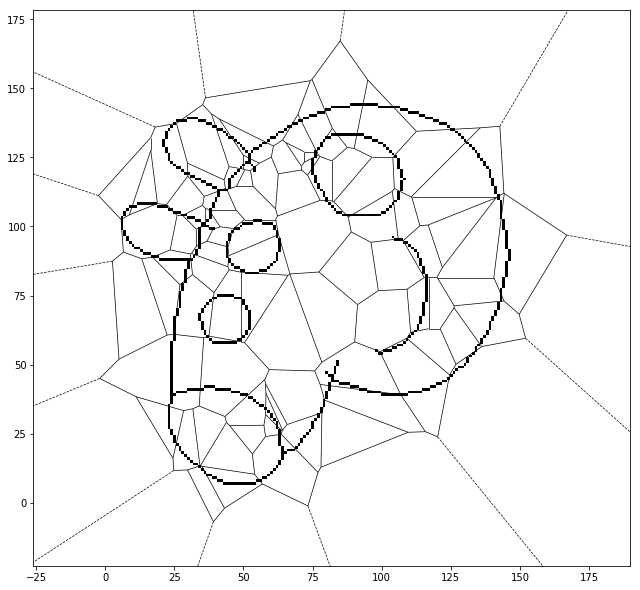

In [347]:
voronoi_plot_2d(peppa_on_skeleton_intervals_1, line_width = 0.7, show_vertices = False, show_points = False)
io.imshow(transform.rotate(invert(skeleton_circle[:, ::-1]), 90))
plt.show()

## 4. Image overlap

Get Voronoi diagram as numpy array:

In [64]:
def get_voronoi_array(voronoi, line_width=3, size=(150,150), fname="vor.png"):
    p = voronoi_plot_2d(voronoi, line_width = 3, show_vertices = False, show_points = False)
    a = p.gca()
    a.set_xticks([]); a.set_yticks([])
    a.axis('off')
    a.set_frame_on(False)
    p.tight_layout()
    p.canvas.draw()

    # grab the pixel buffer and dump it into a numpy array
    read_voronoi = np.array(p.canvas.renderer._renderer)
    
    a.clear()
    plt.close(p)
    
    # Read dumped diagram
    read_voronoi = transform.resize(read_voronoi, size, mode="constant")
    read_voronoi = invert(color.rgb2gray(read_voronoi).round())
    
    return read_voronoi

In [56]:
%%time
read_voronoi = get_voronoi_array(peppa_intersect)

Wall time: 174 ms


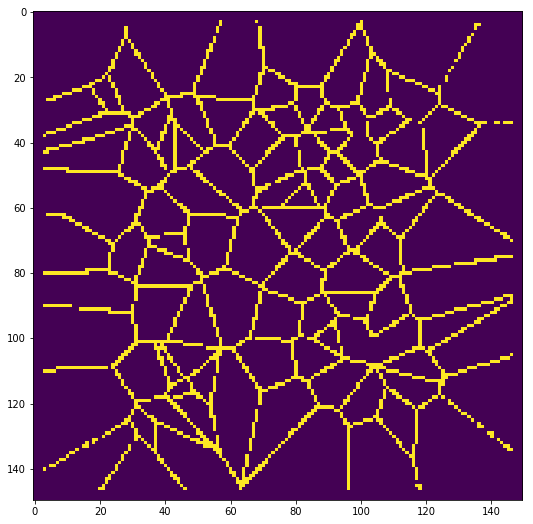

In [57]:
plt.imshow(read_voronoi)
plt.show()

Define fitness function (number of pixels both in reference image and in diagram):

In [84]:
def fitness_function_intersect(voronoi, picture):
    voronoi_im = get_voronoi_array(voronoi)
    return np.sum(voronoi_im[np.where(picture == 1)])

In [77]:
fitness_function_intersect(peppa_intersect, skeleton_peppa)

145.0

Genetic optimization:

In [152]:
def gen_best_intersect(n_generations, n_points, pop=[], pop_size=30, fig_width=100, fig_height=100, n_top=5,
                       mut_rate=0.1, mut_step=3, reference_image=image, skeleton_points=sk_pts):
    # If initial population not specified, create new with points on skeleton
    if not pop:
        pop = population_on_skeleton(n_points, pop_size, fig_width, fig_height, skeleton_points)
    # Selection: choose best individuals
    chosen = sorted(pop, key=lambda x: fitness_function_intersect(x, reference_image), reverse=True)[:n_top]
    # Calculate top score
    best_score = fitness_function_intersect(chosen[0], reference_image)
    
    for g in range(n_generations):
        try:
            # Print out current results
            print('Generation:', g, 'Best score:', best_score, end='\r')
            new_gen = []
            # Choose points for crossover
            offspring_points = np.array([chosen[random.choice(range(n_top))].points[i] for i in range(n_points)])
            # Crossover
            offspring = Voronoi(offspring_points)

            for o in range(pop_size):
                # Select points for mutation
                mut_indices = np.random.choice(range(n_points), int(n_points*mut_rate), replace=False)
                # Introduce mutation
                mut_points = np.array([[point[0] + random.choice(range(-mut_step, mut_step+1)),
                                        point[1] + random.choice(range(-mut_step, mut_step+1))] 
                                       if i in mut_indices
                                       else point
                                       for i, point in enumerate(offspring.points)])
                new_gen.append(Voronoi(mut_points))
            pop = new_gen
            # Selection
            chosen = sorted(pop, key=lambda x: fitness_function_intersect(x, reference_image), reverse=True)[:n_top]
            # Calculate top score
            best_score = fitness_function_intersect(chosen[0], reference_image)
        except KeyboardInterrupt:
            return chosen[0]
    return chosen[0]